# CHAPTER 05. 회귀

- 경사 하강법(Gradient descent)으로 회귀 계수(Regression coefficients) 찾음

## 04. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측



In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

boston = load_boston()

boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df["PRICE"] = boston.target

boston_df.head(3)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [52]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


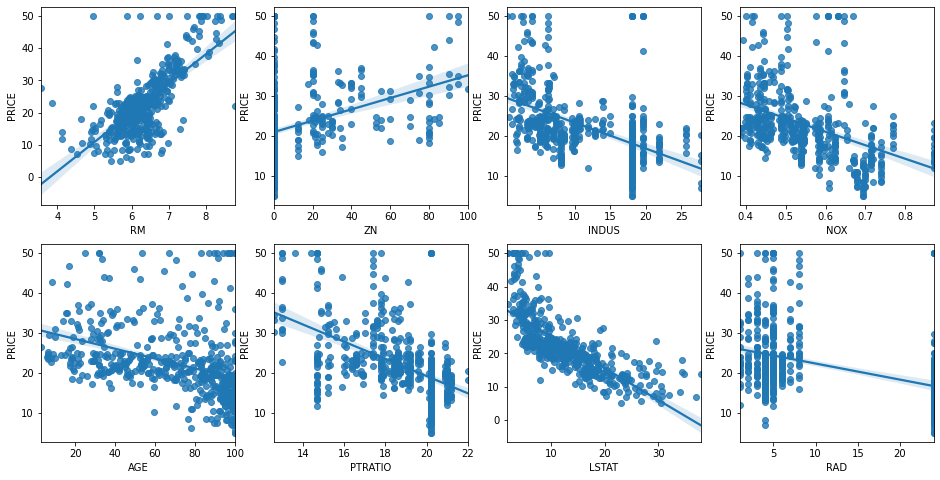

In [53]:
fig, axs = plt.subplots(figsize = (16,8), ncols = 4, nrows = 2)
lm_features = ["RM", "ZN", "INDUS", "NOX", "AGE", "PTRATIO", "LSTAT", "RAD"]

for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x = feature, y = "PRICE", data = boston_df, ax = axs[row][col])

# RM : 방개수 : 양의 상관관계
# LSTAT: 하위계층 비율 : 음의 상관관계

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
y_target = boston_df["PRICE"]
X_data = boston_df.drop(["PRICE"], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print("MSE: ", mse, "RMSE: ", rmse)
print("Variance score: ", r2_score(y_test, pred))


MSE:  17.29691590790215 RMSE:  4.158956107955715
Variance score:  0.7572263323138921


In [55]:
print("절편: ", lr.intercept_)
print("계수: ", np.round(lr.coef_, 1))


절편:  40.995595172164336
계수:  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [56]:
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)


RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [57]:
from sklearn.model_selection import cross_val_score

neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5 folds neg mse :", np.round(neg_mse_scores, 2))
print("5 folds rmse: ", np.round(rmse_scores, 2))
print("rmse mean: ", avg_rmse)


5 folds neg mse : [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds rmse:  [3.53 5.1  5.75 8.99 5.77]
rmse mean:  5.828658946215808


## 05. 다항 회귀와 과(대)적합/과소적합 이해

- 다항회귀가 선형회귀가 아니라는 뜻은 아님, 선형 비선형은 계수가 선형인지 비선형인지에 따라
- 명시적으로 다항회귀를 위한 클래스는 없음 비선형 모델을 선형 모델에 적용하는 방법으로...


In [58]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X = np.arange(4).reshape(2, 2)

print("X:\n", X)

poly = PolynomialFeatures(degree = 2)
poly.fit(X)
poly_ftr = poly.transform(X)
print("변환된 2차 다항식 계수 피처:\n", poly_ftr)
#(x1, x2) 에 대해 (1, x1, x2, x1^2, x1x2, x2^2) 값 반환


X:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [59]:
# 3차

def polynomial_func(X):
    y = 1 + 2 * X[:, 0] + 3 * X[:, 0] ** 2 + 4 * X[:, 1] ** 3
    return y

X = np.arange(4).reshape(2, 2)
# (1,2) , (3,4)
print("X:\n", X)
y = polynomial_func(X)
print(y)


X:
 [[0 1]
 [2 3]]
[  5 125]


In [60]:
poly_ftr = PolynomialFeatures(degree = 3).fit_transform(X)
print("poly_ftr\n", poly_ftr)

model = LinearRegression()
model.fit(poly_ftr, y)

print("Polynomial 회귀 계수\n", np.round(model.coef_,4))
print("Plynomial 회귀 shape: ", model.coef_.shape)

poly_ftr
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.     0.1802 0.1802 0.3604 0.5405 0.7207 0.7207 1.0811 1.6216 2.3423]
Plynomial 회귀 shape:  (10,)


In [61]:
# 밑 방법이 더 명료
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


model = Pipeline([("poly", PolynomialFeatures(degree = 3)), ("linear", LinearRegression())])
X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)
model = model.fit(X, y)

print("coef_ :\n", np.round(model.named_steps["linear"].coef_, 3))

coef_ :
 [0.    0.18  0.18  0.36  0.541 0.721 0.721 1.081 1.622 2.342]


### 다항 회귀를 이용한 과소적합 및 과적합 이해


Degree 1 회귀 계수는 [-1.61]
Degree 1 MSE 는 0.40772896250986834
Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26]
Degree 4 MSE 는 0.04320874987231718
Degree 15 회귀 계수는 [-2.98295000e+03  1.03899930e+05 -1.87417069e+06  2.03717225e+07
 -1.44873988e+08  7.09318780e+08 -2.47066977e+09  6.24564048e+09
 -1.15677067e+10  1.56895696e+10 -1.54006776e+10  1.06457788e+10
 -4.91379977e+09  1.35920330e+09 -1.70381654e+08]
Degree 15 MSE 는 182815433.5604608


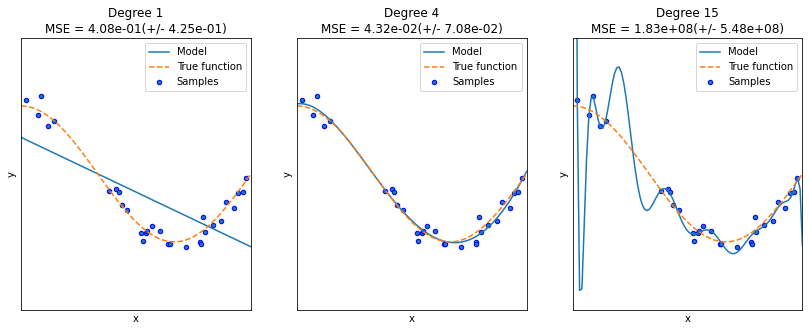

In [62]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

y = true_fun(X) + np.random.randn(n_samples) * 0.1 # 노이즈 더함

plt.figure(figsize = (14, 5))
degrees = [1, 4, 15]

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks = (), yticks = ())

    polynomial_features = PolynomialFeatures(degree = degrees[i], include_bias = False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)

    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring = "neg_mean_squared_error", cv = 10)
    coefficients = pipeline.named_steps["linear_regression"].coef_

    print(f"Degree {degrees[i]} 회귀 계수는 {np.round(coefficients, 2)}")
    print(f"Degree {degrees[i]} MSE 는 {-1 * np.mean(scores)}")

    X_test = np.linspace(0, 1, 100)

    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label = "Model")

    plt.plot(X_test, true_fun(X_test), "--", label = "True function")
    plt.scatter(X, y, edgecolors = "b", s = 20, label = "Samples")

    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc = "best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))
plt.show()
# 차수 높아질 수록 모든 데이터 다 표현하려고 해서 과적합. (학습 데이터만 정확히 예측)
# 차수 너무 낮으면 과소 적합.

### 편향-분산 트레이드오프(Bias-Variance Trade off)

- 일반적으로 bias, variance 음의 상관관계 
    - 편향 크면 분산 낮, 과소적합되기 쉬움
    - 편향 작 분산 크, 과대적합되기 쉬움
- 편향 분산 적절, cost 최대로 낮아지는 모델이 좋다.


## 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

- alpha 클 수록 회귀 계수 값의 크기를 감소시켜 과적합 억제 할 수 있음.
- 규제 : alpha 로 페널티 부여해 회귀계수 감소시켜 과적합 개선하는 방식
    - L2: W의 제곱에 대해 패널티 부여. (릿지)
    - L1: W의 절댓값에 대해 패널티 부여 (라쏘) -> 영향력 크지 않은 회귀 계수 값을 0 으로 변환



### 릿지 회귀



In [63]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(neg_mse_scores)
print(rmse_scores)
print(avg_rmse)


[-11.4217962  -24.29446706 -28.14355069 -74.59916618 -28.51714218]
[3.3796148  4.92894178 5.30504955 8.63708088 5.3401444 ]
5.518166280868971


In [64]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print("alpha :" , alpha, "avg_rmse: ", avg_rmse)


alpha : 0 avg_rmse:  5.828658946215806
alpha : 0.1 avg_rmse:  5.788486627032412
alpha : 1 avg_rmse:  5.652570965613545
alpha : 10 avg_rmse:  5.518166280868971
alpha : 100 avg_rmse:  5.329589628472143


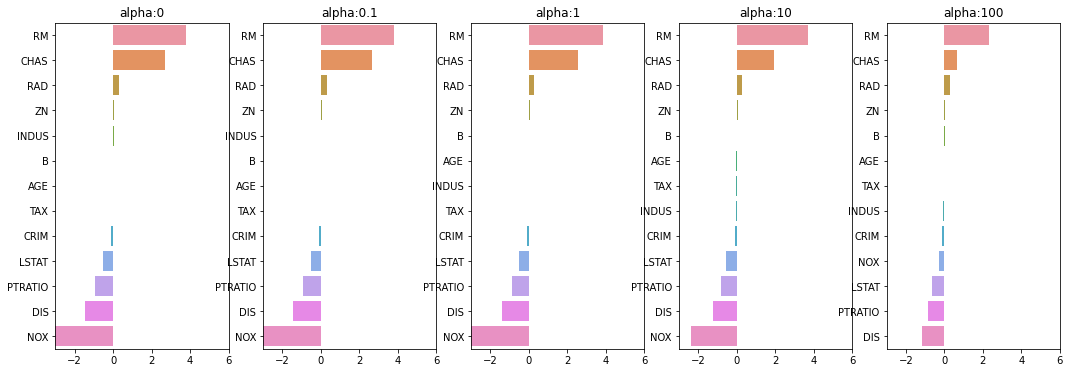

In [65]:
# alpha 에 따른 각 회귀 계수 값 시각화

fig, axs = plt.subplots(figsize = (18, 6), nrows = 1, ncols = 5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)

    coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
    colname = "alpha:" + str(alpha)
    coeff_df[colname] = coeff

    coeff = coeff.sort_values(ascending = False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x = coeff.values, y = coeff.index, ax = axs[pos])

plt.show()

In [66]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = "alpha:" + str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)
# 알파 커질 수록 회귀 계수 작아지는데 릿지는 0으로 만들지는 않음.


,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


### 라쏘 회귀

- 불필요한 회귀 계수 급격하게 감소시켜 0으로 만들고 제거.
- 적절한 피처만 회귀에 포함시킴


In [67]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params = None, X_data_n = None, y_target_n = None, verbose = True):
    coeff_df = pd.DataFrame()
    
    if verbose: print("###### ", model_name, " ######")
    for param in params:
        if model_name == "Ridge": model = Ridge(alpha = param)
        elif model_name == "Lasso": model = Lasso(alpha = param)
        elif model_name == "ElasticNet": model = ElasticNet(alpha = param, l1_ratio = 0.7)

        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = "neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))

        print(f"alpha {param}일 때 폴드 세트의 평균 RMSE: {np.round(avg_rmse, 3)}")

        model.fit(X_data, y_target)
        coeff = pd.Series(data = model.coef_, index = X_data.columns)
        colname = "alpha:" + str(param)
        coeff_df[colname] = coeff
    return coeff_df

In [68]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval("Lasso", lasso_alphas, X_data, y_target)

######  Lasso  ######
alpha 0.07일 때 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 폴드 세트의 평균 RMSE: 6.189


In [69]:
coeff_lasso_df.sort_values(by = "alpha:0.07", ascending = False)
# 라쏘 영향 낮은거 0으로 만들어 버림

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


### 엘라스틱넷 회귀

- L2, L1 합한걸 최소화
- 라쏘에서 알파에 따라 회귀계수가 급격하게 변하는걸 완화시킴.
- 수행시간 오래걸림


In [70]:
coeff_elastic_df = get_linear_reg_eval("ElasticNet", lasso_alphas, X_data, y_target)


######  ElasticNet  ######
alpha 0.07일 때 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 폴드 세트의 평균 RMSE: 6.068


In [71]:
coeff_elastic_df.sort_values(by = "alpha:0.07", ascending = False)
# 라쏘 보다는 0 적게 됨


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


### 선형 회귀 모델을 위한 데이터 변환

1. 정규화 (별로 성능 향상 없음)
2. 정규화된 데이터에 다시 다항 특성 적용 (과적합 가능성 늘어남)
3. 로그 변환 (보통 많이 함)

- 타깃값은 일반적으로 로그 변환

In [72]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_scaled_data(method = "None", p_degree = None, input_data = None):
    if method == "Standard":
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == "MinMax":
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == "Log":
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree = p_degree, include_bias = False).fit_transform(scaled_data)
    
    return scaled_data


In [73]:
alphas = [0.1, 1, 10, 100]

scale_methods = [(None, None), ("Standard", None), ("Standard", 2), ("MinMax", None), ("MinMax", 2), ("Log", None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(scale_method[0], scale_method[1], X_data)
    print(f"\n({scale_method[0]}, {scale_method[1]})")
    get_linear_reg_eval("Ridge", alphas, X_data_scaled, y_target, verbose = False)

# 로그 변환 좋다


(None, None)
alpha 0.1일 때 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 폴드 세트의 평균 RMSE: 5.33

(Standard, None)
alpha 0.1일 때 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 폴드 세트의 평균 RMSE: 5.421

(Standard, 2)
alpha 0.1일 때 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 폴드 세트의 평균 RMSE: 4.634

(MinMax, None)
alpha 0.1일 때 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 폴드 세트의 평균 RMSE: 7.635

(MinMax, 2)
alpha 0.1일 때 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 폴드 세트의 평균 RMSE: 6.538

(Log, None)
alpha 0.1일 때 폴드 세트의 평균 RMSE: 4.77
alpha 1일 때 폴드 세트의 평균 RMSE: 4.676
alpha 10일 때 폴드 세트의 평균 RMSE: 4.836
alpha 100일 때 폴드 세트의 평균 RMSE: 6.241


## 07. 로지스틱 회귀

- 선형 회귀 방식을 분류에 적용
- 시그모이드 함수 최적선 찾고, 그 값에 따라 분류 결정.

In [74]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = 0)

from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print(accuracy_score(y_test, lr_pred))
print(roc_auc_score(y_test, lr_pred))


0.9766081871345029
0.9715608465608465


In [75]:
from sklearn.model_selection import GridSearchCV

params = {
    "penalty": ["l2", "l1"],
    "C": [0.01, 0.1, 1, 5, 10]
}

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring = "accuracy", cv = 3)
grid_clf.fit(data_scaled, cancer.target)

print(grid_clf.best_params_)
print(grid_clf.best_score_)

{'C': 1, 'penalty': 'l2'}
0.975392184164114


## 08. 회귀 트리



In [76]:
from sklearn.ensemble import RandomForestRegressor

boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)

boston_df["PRICE"] = boston.target
y_target = boston_df["PRICE"]
X_data = boston_df.drop(["PRICE"], axis = 1, inplace = False)

rf = RandomForestRegressor(random_state = 0, n_estimators = 1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(np.round(neg_mse_scores, 2))
print(np.round(rmse_scores, 2))
print(avg_rmse)

[ -7.88 -13.14 -20.57 -46.23 -18.88]
[2.81 3.63 4.54 6.8  4.34]
4.422538982804892


In [77]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print(model.__class__.__name__)
    print(avg_rmse)
    

In [78]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)


DecisionTreeRegressor
5.977957424580515
RandomForestRegressor
4.422538982804892
GradientBoostingRegressor
4.26899822168126
XGBRegressor
4.2510804585563005
LGBMRegressor
4.646441191925675


<AxesSubplot:>

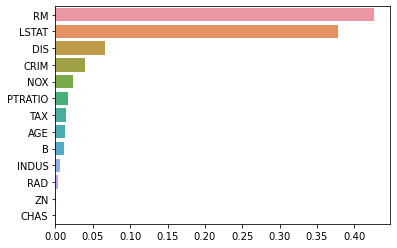

In [79]:
import seaborn as sns

rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series, y = feature_series.index)


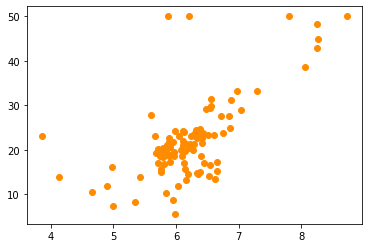

In [80]:
boston_df_sample = boston_df[["RM", "PRICE"]]
boston_df_sample = boston_df_sample.sample(n = 100, random_state = 0)
plt.figure()
plt.scatter(boston_df_sample.RM, boston_df_sample.PRICE, c = "darkorange")


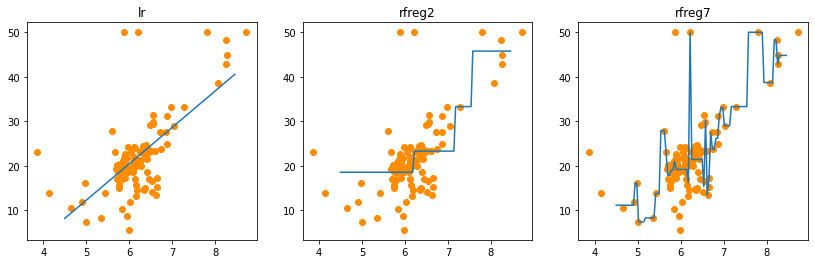

In [81]:
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth = 2)
rf_reg7 = DecisionTreeRegressor(max_depth = 7)

X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

X_feature = boston_df_sample["RM"].values.reshape(-1, 1)
y_target = boston_df_sample["PRICE"].values.reshape(-1, 1)

lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14, 4), ncols = 3)

ax1.set_title("lr")
ax1.scatter(boston_df_sample.RM, boston_df_sample.PRICE, c = "darkorange")
ax1.plot(X_test, lr_reg.predict(X_test))

ax2.set_title("rfreg2")
ax2.scatter(boston_df_sample.RM, boston_df_sample.PRICE, c = "darkorange")
ax2.plot(X_test, rf_reg2.predict(X_test))

ax3.set_title("rfreg7")
ax3.scatter(boston_df_sample.RM, boston_df_sample.PRICE, c = "darkorange")
ax3.plot(X_test, rf_reg7.predict(X_test))


## 09. 회귀 실습 - 자전거 대여 수요 예측



In [82]:
bike_df = pd.read_csv("data/bike_train.csv")
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [83]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [84]:

bike_df["datetime"] = bike_df["datetime"].apply(pd.to_datetime)

bike_df["year"] = bike_df["datetime"].apply(lambda x : x.year)
bike_df["month"] = bike_df["datetime"].apply(lambda x : x.month)
bike_df["day"] = bike_df["datetime"].apply(lambda x : x.day)
bike_df["hour"] = bike_df["datetime"].apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [85]:
bike_df.drop(["datetime", "casual", "registered"], axis = 1, inplace = True)
bike_df.head(3)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


In [88]:
from sklearn.metrics import mean_squared_log_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))


In [90]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [91]:
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

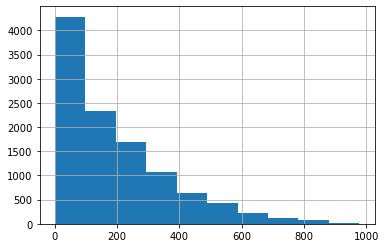

In [92]:
y_target.hist()

<AxesSubplot:>

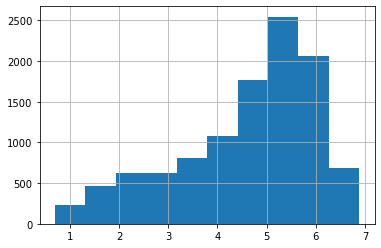

In [93]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [94]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)

pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<AxesSubplot:>

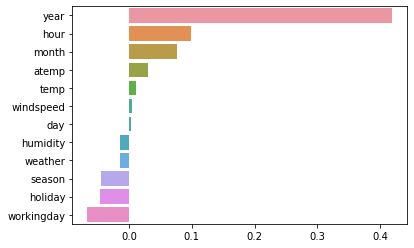

In [95]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [96]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday', 'workingday','season','weather'])

X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)



### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<AxesSubplot:>

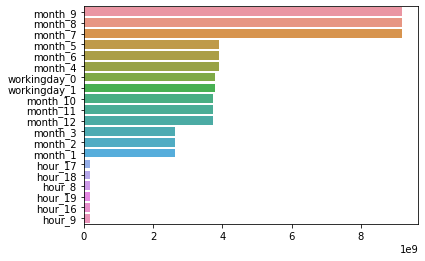

In [97]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)


In [98]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.211, MAE: 31.102
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.321, MAE: 32.737
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
